In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.autograd.functional import hessian, jacobian

In [2]:
dtype = torch.float
#device = torch.device("cuda:0")
device = torch.device("cpu")

# Number of points to train on
num_points = 100

# normalized time domain for ODE
t = torch.linspace(0, 1, num_points, device=device, dtype=dtype, requires_grad=True).reshape(-1,1)

# Make a random symetric + real matrix
Q = torch.randn(6,6, device=device, dtype=dtype, requires_grad=False)
A = torch.transpose(Q, 0, 1) + Q 
A.requires_grad = True

# Initial guess for the eigenvalue
v0 = torch.randn(A.size(0), device=device, dtype=dtype, requires_grad=False).reshape(-1,1)

# Trial solution to ODE
def f_trial(t, N):
    return v0 * torch.exp(-t*100) + (1 - torch.exp(-t*100)) * N

# Shape of network
input_dim = 1
hidden_neurons = 100
output_dim = v0.size(0)

# Create random Tensors for weights.
w1 = torch.randn(input_dim, hidden_neurons, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(hidden_neurons, output_dim, device=device, dtype=dtype, requires_grad=True)

In [3]:
#v0.transpose(0,1).mm(A).mm(v0)
- v0 + (v0.transpose(0,1).mm(v0) * A + (1 - v0.transpose(0,1).mm(A).mm(v0) * torch.eye(v0.size(0)))).mm(v0)

tensor([[10.6911],
        [15.7379],
        [ 6.8398],
        [-0.6731],
        [-4.1671],
        [-0.8914]], grad_fn=<AddBackward0>)

propose a trial solution to the ODE in the form
$$ 
    f_t(t, P) = v_0 \, e^{-t} + (1-e^{-t}) N(t,P)
$$
Where $N$ denotes the Neural Network, and $P$ its free parameters.

In [4]:
def costfunction(t, N, A, trial_func):
    loss = 0
    
    for i in range(t.size(0)):
        # Compute trial eigenvector & transpose
        v = trial_func(t[i], N[i])
        v_T = v.transpose(0,1)
       
        # Time derivative of trial function
        dfdt, dfdN = jacobian(trial_func, (t[i], N[i]), create_graph=True)  
        
        # right hand side of ODE
        RHS = (- v + (v_T.mm(v) * A  + (1 - v_T.mm(A).mm(v) * torch.eye(v.size(0)))).mm(v))
        
        # Increment the loss function
        loss = loss + (dfdt - RHS).pow(2).mean()
    
    return loss / t.size(0)

0: loss =  tensor(366.3965, grad_fn=<DivBackward0>)
10: loss =  tensor(113.4785, grad_fn=<DivBackward0>)
20: loss =  tensor(102.4861, grad_fn=<DivBackward0>)
30: loss =  tensor(98.4074, grad_fn=<DivBackward0>)
40: loss =  tensor(96.2200, grad_fn=<DivBackward0>)
50: loss =  tensor(94.8521, grad_fn=<DivBackward0>)
60: loss =  tensor(93.9013, grad_fn=<DivBackward0>)
70: loss =  tensor(93.1981, grad_fn=<DivBackward0>)
80: loss =  tensor(92.6543, grad_fn=<DivBackward0>)
90: loss =  tensor(92.2195, grad_fn=<DivBackward0>)


Text(0, 0.5, 'Loss')

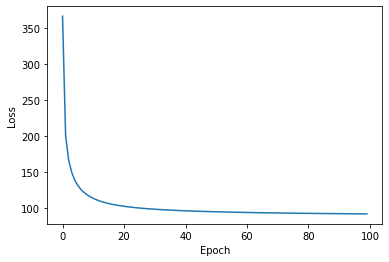

In [5]:
EPOCHS = 100

loss_arr = np.empty(EPOCHS, dtype=np.float)

learning_rate = 0.0002
for epoch in range(EPOCHS):
    N_output = F.relu(t.mm(w1)).mm(w2)
        
    # Compute and print loss    
    loss = costfunction(t, N_output.reshape(-1,1), A, f_trial)
    
    loss_arr[epoch] = loss.detach().numpy()
    
    if epoch % 10 == 0:
        print(f"{epoch}: loss = ",loss)
    
    # Use autograd to compute the backward pass.
    loss.backward()

    # Update weights using gradient descent
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad
    
        # Manually zero the gradients after updating weights
        w1.grad.zero_()
        w2.grad.zero_()
        
plt.plot(loss_arr)
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [6]:
v_pred = f_trial(t[-1,:], N_output[-1,:].reshape(-1,1))

print("before norm: \n",v_pred)
v_pred = v_pred/v_pred.norm()
print("after norm: \n", v_pred)

eigal, eigvec = np.linalg.eigh(A.detach().numpy())
print(eigvec)

before norm: 
 tensor([[-3.7470],
        [ 3.6631],
        [-3.2929],
        [ 3.8691],
        [ 3.8540],
        [-3.7396]], grad_fn=<AddBackward0>)
after norm: 
 tensor([[-0.4135],
        [ 0.4043],
        [-0.3634],
        [ 0.4270],
        [ 0.4253],
        [-0.4127]], grad_fn=<DivBackward0>)
[[-0.06348756  0.4681472  -0.66265756  0.20513904 -0.5096124   0.1894879 ]
 [ 0.05812219 -0.57860726  0.0618549   0.20482644 -0.2615905   0.74001753]
 [ 0.78870726  0.23381296  0.39672974  0.11442536 -0.38275546 -0.07926532]
 [-0.11184807  0.3871381   0.24766254  0.7296812   0.4309212   0.2411423 ]
 [-0.51212895  0.35631984  0.56659174 -0.30392933 -0.38655424  0.21894437]
 [-0.30942842 -0.33844286  0.13153495  0.52731705 -0.43617272 -0.55145186]]
